In [1]:
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import os
import io
import time
import torch.optim as optim

from bpemb import BPEmb

In [2]:
vocab_size = 10000
bpemb_ja = BPEmb(lang='ja', vs=vocab_size, dim=100)
bpemb_en = BPEmb(lang='en', vs=vocab_size, dim=100)

In [3]:
path_to_file = "./datasets/jpn.txt"

lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')

temp_list = []
corpus = []

for i in range(len(lines)):
    temp_list =  lines[i].split('\t')[:-1]
    corpus.append(temp_list)
    

In [4]:
MAX_LENGTH = 40

en, ja = np.array(corpus).T

en_encoded = []
ja_encoded = []

cnt_en = 0
cnt_ja = 0

for i in range(len(en)):
    en_encoded_temp = bpemb_en.encode_ids(en[i])
    ja_encoded_temp = bpemb_ja.encode_ids(ja[i])
    
    if (len(en_encoded_temp)<=MAX_LENGTH) and (len(ja_encoded_temp)<=MAX_LENGTH):
        en_encoded.append([vocab_size] + en_encoded_temp + [vocab_size + 1])
        ja_encoded.append([vocab_size] + ja_encoded_temp + [vocab_size + 1])
    

In [5]:
en_padded = tf.keras.preprocessing.sequence.pad_sequences(en_encoded, padding='post')
ja_padded = tf.keras.preprocessing.sequence.pad_sequences(ja_encoded, padding='post')

In [6]:
embedding_dim = 256
units = 1024
vocab_size = 10000
vocab_inp_size = vocab_size + 2
vocab_tar_size = vocab_size + 2

In [7]:
import os
import numpy as np
import torch
import torch.utils.data


import glob
class EN_JA_Corpus(torch.utils.data.Dataset):
    def __init__(self,  corpus_en, corpus_ja, transforms=None,):
        
        self.corpus_en = corpus_en
        self.corpus_ja = corpus_ja
        

    def __getitem__(self, idx):
        source = torch.tensor(self.corpus_en[idx]).to(dtype=torch.long)
        target = torch.tensor(self.corpus_ja[idx]).to(dtype=torch.long)
        

       # if self.transforms is not None:
         #   img, target = self.transforms(img, target)

        return source, target

    def __len__(self):
        return self.corpus_en.shape[0]



In [8]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [9]:
dataset = EN_JA_Corpus(en_padded, ja_padded)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=64, shuffle=True, num_workers=4)

In [10]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [11]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [12]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return torch.Tensor(pos_encoding)
    


In [13]:
def create_padding_mask(seq):
  seq = torch.eq(seq, 0).to(dtype=torch.float)
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [14]:
def create_look_ahead_mask(size):
    "Mask out subsequent positions."
    attn_shape = (size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return (torch.from_numpy(subsequent_mask) == 1).to(dtype=torch.float)

In [15]:
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """
    
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = torch.matmul(q, k.transpose(len(k.shape)-2, len(k.shape)-1))  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    #print(k.shape)
    dk = torch.Tensor([k.shape[-1]])
    #print(dk)
    scaled_attention_logits = matmul_qk / torch.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    softmax = nn.Softmax(dim=-1)
    attention_weights = softmax(scaled_attention_logits).to(dtype=torch.float)  # (..., seq_len_q, seq_len_k)

    output = torch.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [16]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [17]:
import torch.nn as nn
np.set_printoptions(suppress=True)

temp_k = torch.Tensor([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]])  # (4, 3)

temp_v = torch.Tensor([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]])  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = torch.Tensor([[0, 10, 0]])  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tensor([[8.4333e-26, 1.0000e+00, 8.4333e-26, 8.4333e-26]])
Output is:
tensor([[1.0000e+01, 9.2766e-25]])


In [18]:
import torch.nn as nn 
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = nn.Linear(in_features=d_model , out_features=d_model)
    self.wk = nn.Linear(in_features=d_model , out_features=d_model)
    self.wv = nn.Linear(in_features=d_model , out_features=d_model)
        
    self.dense = nn.Linear(in_features=d_model, out_features=d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = torch.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return x.permute([0, 2, 1, 3])
    
  def forward(self, v, k, q, mask=None):
    batch_size = q.shape[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = scaled_attention.permute([0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = torch.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [19]:
sample_query = np.arange(1*9*512).reshape((1, 9, 512)) + 1
sample_query = torch.tensor(sample_query)
print(sample_query.shape)
print(sample_query)

torch.Size([1, 9, 512])
tensor([[[   1,    2,    3,  ...,  510,  511,  512],
         [ 513,  514,  515,  ..., 1022, 1023, 1024],
         [1025, 1026, 1027,  ..., 1534, 1535, 1536],
         ...,
         [3073, 3074, 3075,  ..., 3582, 3583, 3584],
         [3585, 3586, 3587,  ..., 4094, 4095, 4096],
         [4097, 4098, 4099,  ..., 4606, 4607, 4608]]])


In [20]:
sample_query = torch.reshape(sample_query, (1, 9, 8, 64))
print(sample_query.shape)
print(sample_query)

torch.Size([1, 9, 8, 64])
tensor([[[[   1,    2,    3,  ...,   62,   63,   64],
          [  65,   66,   67,  ...,  126,  127,  128],
          [ 129,  130,  131,  ...,  190,  191,  192],
          ...,
          [ 321,  322,  323,  ...,  382,  383,  384],
          [ 385,  386,  387,  ...,  446,  447,  448],
          [ 449,  450,  451,  ...,  510,  511,  512]],

         [[ 513,  514,  515,  ...,  574,  575,  576],
          [ 577,  578,  579,  ...,  638,  639,  640],
          [ 641,  642,  643,  ...,  702,  703,  704],
          ...,
          [ 833,  834,  835,  ...,  894,  895,  896],
          [ 897,  898,  899,  ...,  958,  959,  960],
          [ 961,  962,  963,  ..., 1022, 1023, 1024]],

         [[1025, 1026, 1027,  ..., 1086, 1087, 1088],
          [1089, 1090, 1091,  ..., 1150, 1151, 1152],
          [1153, 1154, 1155,  ..., 1214, 1215, 1216],
          ...,
          [1345, 1346, 1347,  ..., 1406, 1407, 1408],
          [1409, 1410, 1411,  ..., 1470, 1471, 1472],
       

In [21]:
sample_query = sample_query.permute([0, 2, 1, 3])
print(sample_query.shape)
print(sample_query)

torch.Size([1, 8, 9, 64])
tensor([[[[   1,    2,    3,  ...,   62,   63,   64],
          [ 513,  514,  515,  ...,  574,  575,  576],
          [1025, 1026, 1027,  ..., 1086, 1087, 1088],
          ...,
          [3073, 3074, 3075,  ..., 3134, 3135, 3136],
          [3585, 3586, 3587,  ..., 3646, 3647, 3648],
          [4097, 4098, 4099,  ..., 4158, 4159, 4160]],

         [[  65,   66,   67,  ...,  126,  127,  128],
          [ 577,  578,  579,  ...,  638,  639,  640],
          [1089, 1090, 1091,  ..., 1150, 1151, 1152],
          ...,
          [3137, 3138, 3139,  ..., 3198, 3199, 3200],
          [3649, 3650, 3651,  ..., 3710, 3711, 3712],
          [4161, 4162, 4163,  ..., 4222, 4223, 4224]],

         [[ 129,  130,  131,  ...,  190,  191,  192],
          [ 641,  642,  643,  ...,  702,  703,  704],
          [1153, 1154, 1155,  ..., 1214, 1215, 1216],
          ...,
          [3201, 3202, 3203,  ..., 3262, 3263, 3264],
          [3713, 3714, 3715,  ..., 3774, 3775, 3776],
       

In [22]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = torch.ones((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, y, y)
out.shape, attn.shape

(torch.Size([1, 60, 512]), torch.Size([1, 8, 60, 60]))

In [23]:
def point_wise_feed_forward_network(d_model, dff):
    return nn.Sequential(
      nn.Linear(in_features=d_model, out_features=dff),  # (batch_size, seq_len, dff)
      nn.ReLU(),
      nn.Linear(in_features=dff, out_features=d_model)  # (batch_size, seq_len, d_model)
    )

In [24]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = nn.LayerNorm(d_model, eps=1e-6)
    self.layernorm2 = nn.LayerNorm(d_model, eps=1e-6)
    
    self.dropout1 = nn.Dropout(p=rate)
    self.dropout2 = nn.Dropout(p=rate)
    
  def forward(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [25]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    torch.ones((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

torch.Size([64, 43, 512])

In [26]:
class DecoderLayer(nn.Module):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = nn.LayerNorm(d_model, eps=1e-6)
    self.layernorm2 = nn.LayerNorm(d_model, eps=1e-6)
    self.layernorm3 = nn.LayerNorm(d_model, eps=1e-6)
    
    self.dropout1 = nn.Dropout(p=rate)
    self.dropout2 = nn.Dropout(p=rate)
    self.dropout3 = nn.Dropout(p=rate)
    
    
  def forward(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [27]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _,_ = sample_decoder_layer(
    torch.ones((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

torch.Size([64, 50, 512])

In [28]:
class Encoder(nn.Module):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    #self.pre_embedding = tf.keras.layers.Dense(input_vocab_size, 100)
    
    self.embedding = nn.Embedding(num_embeddings=input_vocab_size, embedding_dim=d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = nn.Dropout(p=rate)
        
  def forward(self, x, training, mask):

    seq_len = x.shape[1]
    
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)    
    x *= torch.sqrt(torch.Tensor([self.d_model]))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x)    
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)


In [29]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
#temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
temp_input = np.random.randint(8500, size=(64, 62))
temp_input = torch.tensor(temp_input)
#temp_input = torch.rand((64, 62))
sample_encoder_output = sample_encoder(temp_input,  training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

torch.Size([64, 62, 512])


In [30]:
class Decoder(nn.Module):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    #self.pre_embedding = tf.keras.layers.Dense(target_vocab_size, 100)
    
    self.embedding = nn.Embedding(num_embeddings=target_vocab_size, embedding_dim=d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = nn.Dropout(p=rate)
    
  def forward(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    #print("The shape of 'x' is " + str(tf.shape(x)))

    seq_len = x.shape[1]
    #print("'seq_len' is " + str(seq_len))
    
    
    #x = self.pre_embedding(x)

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= torch.sqrt(torch.Tensor([self.d_model]))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
    
    # x.shape == (batch_size, target_seq_len, d_model)
    #print("The shape of 'x' is " + str(tf.shape(x)))
    
    return x, _

In [31]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
#temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)
temp_input = np.random.randint(8000, size=(64, 26))
temp_input = torch.tensor(temp_input)
#temp_input = torch.rand((64, 62))

output, _ = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape

torch.Size([64, 26, 512])

In [32]:
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
temp_input.shape

TensorShape([64, 62])

In [33]:
class Transformer(nn.Module):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = nn.Linear(in_features=d_model , out_features=target_vocab_size)
    
  def forward(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    #print('enc_output')
    #print(enc_output)
    
    #dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [34]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

#temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
#temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

temp_input = np.random.randint(8500, size=(64, 38))
temp_input = torch.tensor(temp_input)

temp_target = np.random.randint(8000, size=(64, 36))
temp_target = torch.tensor(temp_target)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

torch.Size([64, 36, 8000])

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = torch.Tensor([self.d_model])

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = torch.rsqrt(torch.Tensor(step))
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return torch.rsqrt(self.d_model) * torch.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

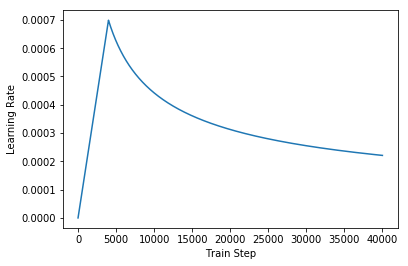

In [36]:
d_model = 512
temp_learning_rate_schedule = CustomSchedule(d_model)

#plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.plot(temp_learning_rate_schedule(torch.arange(0, 40000).to(dtype=torch.float)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [37]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = vocab_size + 2
target_vocab_size = vocab_size + 2
dropout_rate = 0.1

In [38]:
# Testing nn.CrossEntropyLoss()
y_true = [1, 2]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]

loss = nn.CrossEntropyLoss(reduce=False)
input = torch.tensor(y_pred)
target = torch.tensor(y_true)
output = loss(input, target)

print(output)

tensor([0.5841, 1.3897])


/Users/tamurataito/opt/anaconda3/envs/transformer_env/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [39]:
loss_object = nn.CrossEntropyLoss(reduce=False)

def loss_function(pred, real):
    mask = torch.logical_not(torch.eq(real, 0))
    loss_ = loss_object(pred.to(dtype=torch.float), real.to(dtype=torch.long))
    loss_ *= mask
  
    return torch.sum(loss_)/torch.sum(mask)

In [40]:
# Testing loss_function()
loss_function(input, target)

tensor(0.9869)

In [41]:
def train_step(inp, tar, batch_number):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    predictions, _ = model(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
    
    loss = 0
    for i in range(inp.shape[0]):
        loss = loss + loss_function(predictions[i], tar_real[i])
    
    if(batch_number % 100 == 0):
        print('loss: ' + str(loss.item()))
  
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



In [42]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tar.shape[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = torch.maximum(dec_target_padding_mask, look_ahead_mask)
  
    #return enc_padding_mask.to(dtype=torch.long), combined_mask.to(dtype=torch.long), dec_padding_mask.to(dtype=torch.long)
    
    return enc_padding_mask, combined_mask, dec_padding_mask
    

In [43]:
loss

CrossEntropyLoss()

In [44]:
# Checking how the data loader works
for i, data in enumerate(data_loader):
    print(i)
    print(data[0].shape, data[1].shape)

0
torch.Size([64, 42]) torch.Size([64, 42])
1
torch.Size([64, 42]) torch.Size([64, 42])
2
torch.Size([64, 42]) torch.Size([64, 42])
3
torch.Size([64, 42]) torch.Size([64, 42])
4
torch.Size([64, 42]) torch.Size([64, 42])
5
torch.Size([64, 42]) torch.Size([64, 42])
6
torch.Size([64, 42]) torch.Size([64, 42])
7
torch.Size([64, 42]) torch.Size([64, 42])
8
torch.Size([64, 42]) torch.Size([64, 42])
9
torch.Size([64, 42]) torch.Size([64, 42])
10
torch.Size([64, 42]) torch.Size([64, 42])
11
torch.Size([64, 42]) torch.Size([64, 42])
12
torch.Size([64, 42]) torch.Size([64, 42])
13
torch.Size([64, 42]) torch.Size([64, 42])
14
torch.Size([64, 42]) torch.Size([64, 42])
15
torch.Size([64, 42]) torch.Size([64, 42])
16
torch.Size([64, 42]) torch.Size([64, 42])
17
torch.Size([64, 42]) torch.Size([64, 42])
18
torch.Size([64, 42]) torch.Size([64, 42])
19
torch.Size([64, 42]) torch.Size([64, 42])
20
torch.Size([64, 42]) torch.Size([64, 42])
21
torch.Size([64, 42]) torch.Size([64, 42])
22
torch.Size([64, 4

182
torch.Size([64, 42]) torch.Size([64, 42])
183
torch.Size([64, 42]) torch.Size([64, 42])
184
torch.Size([64, 42]) torch.Size([64, 42])
185
torch.Size([64, 42]) torch.Size([64, 42])
186
torch.Size([64, 42]) torch.Size([64, 42])
187
torch.Size([64, 42]) torch.Size([64, 42])
188
torch.Size([64, 42]) torch.Size([64, 42])
189
torch.Size([64, 42]) torch.Size([64, 42])
190
torch.Size([64, 42]) torch.Size([64, 42])
191
torch.Size([64, 42]) torch.Size([64, 42])
192
torch.Size([64, 42]) torch.Size([64, 42])
193
torch.Size([64, 42]) torch.Size([64, 42])
194
torch.Size([64, 42]) torch.Size([64, 42])
195
torch.Size([64, 42]) torch.Size([64, 42])
196
torch.Size([64, 42]) torch.Size([64, 42])
197
torch.Size([64, 42]) torch.Size([64, 42])
198
torch.Size([64, 42]) torch.Size([64, 42])
199
torch.Size([64, 42]) torch.Size([64, 42])
200
torch.Size([64, 42]) torch.Size([64, 42])
201
torch.Size([64, 42]) torch.Size([64, 42])
202
torch.Size([64, 42]) torch.Size([64, 42])
203
torch.Size([64, 42]) torch.Siz

421
torch.Size([64, 42]) torch.Size([64, 42])
422
torch.Size([64, 42]) torch.Size([64, 42])
423
torch.Size([64, 42]) torch.Size([64, 42])
424
torch.Size([64, 42]) torch.Size([64, 42])
425
torch.Size([64, 42]) torch.Size([64, 42])
426
torch.Size([64, 42]) torch.Size([64, 42])
427
torch.Size([64, 42]) torch.Size([64, 42])
428
torch.Size([64, 42]) torch.Size([64, 42])
429
torch.Size([64, 42]) torch.Size([64, 42])
430
torch.Size([64, 42]) torch.Size([64, 42])
431
torch.Size([64, 42]) torch.Size([64, 42])
432
torch.Size([64, 42]) torch.Size([64, 42])
433
torch.Size([64, 42]) torch.Size([64, 42])
434
torch.Size([64, 42]) torch.Size([64, 42])
435
torch.Size([64, 42]) torch.Size([64, 42])
436
torch.Size([64, 42]) torch.Size([64, 42])
437
torch.Size([64, 42]) torch.Size([64, 42])
438
torch.Size([64, 42]) torch.Size([64, 42])
439
torch.Size([64, 42]) torch.Size([64, 42])
440
torch.Size([64, 42]) torch.Size([64, 42])
441
torch.Size([64, 42]) torch.Size([64, 42])
442
torch.Size([64, 42]) torch.Siz

666
torch.Size([64, 42]) torch.Size([64, 42])
667
torch.Size([64, 42]) torch.Size([64, 42])
668
torch.Size([64, 42]) torch.Size([64, 42])
669
torch.Size([64, 42]) torch.Size([64, 42])
670
torch.Size([64, 42]) torch.Size([64, 42])
671
torch.Size([64, 42]) torch.Size([64, 42])
672
torch.Size([64, 42]) torch.Size([64, 42])
673
torch.Size([64, 42]) torch.Size([64, 42])
674
torch.Size([64, 42]) torch.Size([64, 42])
675
torch.Size([64, 42]) torch.Size([64, 42])
676
torch.Size([64, 42]) torch.Size([64, 42])
677
torch.Size([64, 42]) torch.Size([64, 42])
678
torch.Size([64, 42]) torch.Size([64, 42])
679
torch.Size([64, 42]) torch.Size([64, 42])
680
torch.Size([64, 42]) torch.Size([64, 42])
681
torch.Size([64, 42]) torch.Size([64, 42])
682
torch.Size([64, 42]) torch.Size([64, 42])
683
torch.Size([64, 42]) torch.Size([64, 42])
684
torch.Size([64, 42]) torch.Size([64, 42])
685
torch.Size([64, 42]) torch.Size([64, 42])
686
torch.Size([64, 42]) torch.Size([64, 42])
687
torch.Size([64, 42]) torch.Siz

908
torch.Size([64, 42]) torch.Size([64, 42])
909
torch.Size([64, 42]) torch.Size([64, 42])
910
torch.Size([64, 42]) torch.Size([64, 42])
911
torch.Size([64, 42]) torch.Size([64, 42])
912
torch.Size([64, 42]) torch.Size([64, 42])
913
torch.Size([64, 42]) torch.Size([64, 42])
914
torch.Size([64, 42]) torch.Size([64, 42])
915
torch.Size([64, 42]) torch.Size([64, 42])
916
torch.Size([64, 42]) torch.Size([64, 42])
917
torch.Size([64, 42]) torch.Size([64, 42])
918
torch.Size([64, 42]) torch.Size([64, 42])
919
torch.Size([64, 42]) torch.Size([64, 42])
920
torch.Size([64, 42]) torch.Size([64, 42])
921
torch.Size([64, 42]) torch.Size([64, 42])
922
torch.Size([64, 42]) torch.Size([64, 42])
923
torch.Size([64, 42]) torch.Size([64, 42])
924
torch.Size([64, 42]) torch.Size([64, 42])
925
torch.Size([64, 42]) torch.Size([64, 42])
926
torch.Size([64, 42]) torch.Size([64, 42])
927
torch.Size([64, 42]) torch.Size([64, 42])
928
torch.Size([64, 42]) torch.Size([64, 42])
929
torch.Size([64, 42]) torch.Siz

In [45]:
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=64, shuffle=True, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

learning_rate = CustomSchedule(d_model)
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
EPOCHS = 20

model.train()
for epoch in range(EPOCHS):
    print("Epoch {}".format(epoch))
    print()
    for i, data in enumerate(data_loader):
        if(i%100 == 0):
            print("batch {}".format(i+1))
        train_step(data[0], data[1], i+1)
    
    outfile = "./torch_transformer_checkpoints/test_1_epoch" + str(epoch + 1) + ".model"
    torch.save(model.state_dict(), outfile)
    print(outfile + " saved")

Epoch 0

batch 1


KeyboardInterrupt: 